In [1]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.timeseries import BoxLeastSquares


In [2]:
data = np.genfromtxt('XO2N_PDCSAP_flattened_biweight.dat')
# You can use "panda" as well, this is the simplest way since we are not dealing with complex databases

time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]


In [3]:
# BLS
model_bls = BoxLeastSquares(time, flux, dy=flux_err)
periodogram = model_bls.autopower(0.1, minimum_period=0.3, maximum_period=8, minimum_n_transit=3,  objective="snr")
# pay attention to the maximum period
# we want at least 3 transits to talk about an exoplanet. This way, any flare is ruled out

<IPython.core.display.Javascript object>


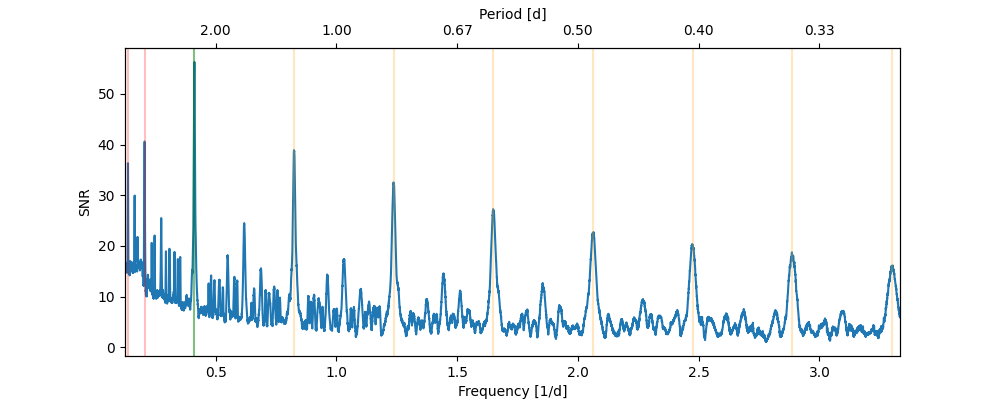

In [4]:
# REMEMBER: periodograms must always go on frequency scale

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(111)

ax1.plot(1./periodogram.period, periodogram.power)

ax1.set_xlabel("Frequency [1/d]")
ax1.set_ylabel("SNR")


#Magic trick that I learnt in the past and now I forgot how it works
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = ax1.twiny()
ax1.get_shared_x_axes().join(ax1,ax2)

# This must be put here, otherwise it will not work!
ax1.set_xlim(np.amin(1./periodogram.period), np.amax(1./periodogram.period))


f = lambda q: 1./q
finv = lambda x: 1./x
ax2.xaxis.set_major_formatter(FuncFormatter(lambda k,pos: f"{finv(k):.2f}"))
ax2.set_xlabel('Period [d]')

# period from Exoplanet archive
known_period = 2.423823 # Gaudi+2017

# multiple of the period
for ii in range(2,5):
    ax1.axvline(1./(ii*known_period), c='red', alpha=0.25)

# fraction of periods
for ii in range(2,10):
    ax1.axvline(1./(known_period/ii), c='orange', alpha=0.25)

ax1.axvline(1./known_period, c='green', alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


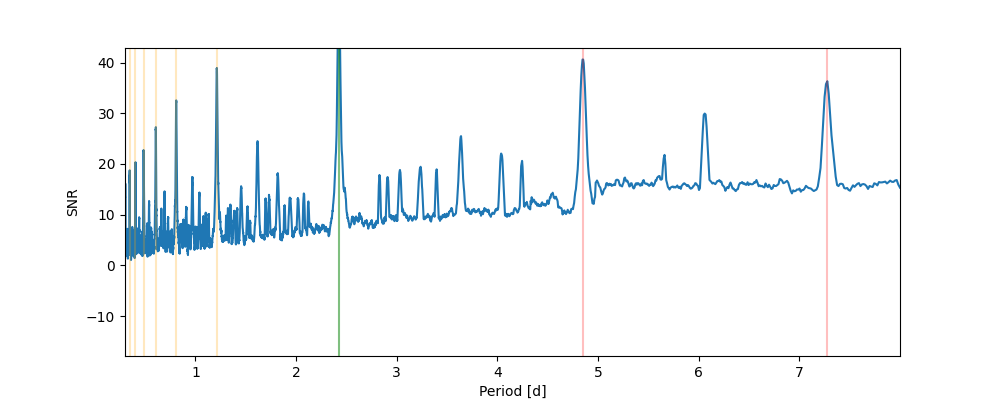

In [5]:
# Ok let's make in Period because it makes sense in this case

plt.figure(figsize=(10,4))

plt.plot(periodogram.period, periodogram.power)

plt.xlabel("Period [d]")
plt.ylabel("SNR")

# This must be put here, otherwise it will not work!
plt.xlim(np.amin(periodogram.period), np.amax(periodogram.period))

# period from Exoplanet archive
# multiple of the period
for ii in range(2,5):
    plt.axvline(ii*known_period, c='red', alpha=0.25)

# fraction of period
for ii in range(2,10):
    plt.axvline(known_period/ii, c='orange', alpha=0.25)

plt.axvline(known_period, c='green', alpha=0.5)
plt.show()

## Choose the most prominent peak


Period with max Power: P= 2.4255 days, Tc = 2458386.5730. 
Depth and duration: 0.0112 %, T14 = 0.1000. 
Alternative Epoch: 2458403.551301864


<IPython.core.display.Javascript object>


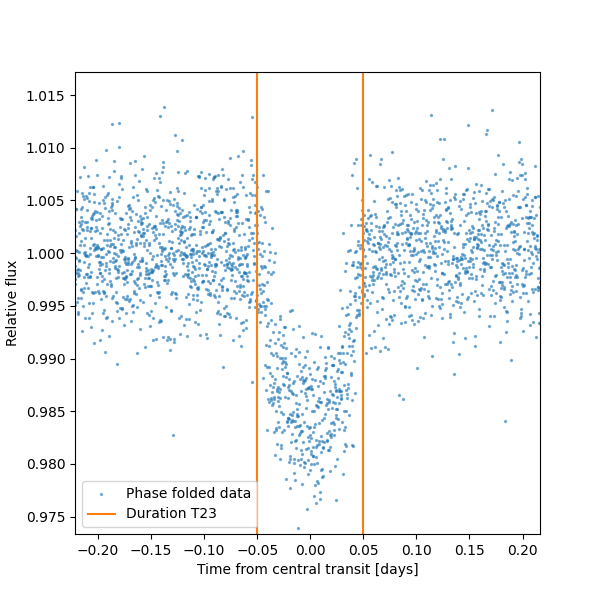

In [6]:
max_power = np.argmax(periodogram.power)
period_bls = periodogram.period[max_power]
epoch_bls = periodogram.transit_time[max_power]
depth_bls = (periodogram.depth[max_power])
duration_bls = periodogram.duration[max_power]

print('Period with max Power: P= {:.4f} days, Tc = {:.4f}. '
      .format(period_bls, epoch_bls))
print('Depth and duration: {:.4f} %, T14 = {:.4f}. '
      .format(depth_bls, duration_bls))

# Compute stats:
stats = model_bls.compute_stats(periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])

print('Alternative Epoch: {}'.format(stats['transit_times'][-1]))
epoch_bls = stats['transit_times'][0]

# phase fold plot:
phase = (time - epoch_bls) % period_bls / period_bls
phase[np.where(phase>0.5)] -= 1 


## plot the phase fold
plt.figure(figsize=(6,6))
plt.scatter(phase*period_bls, flux, c='C0', s=2, alpha=0.5, label='Phase folded data')
plt.xlim(-period_bls/2, period_bls/2.)

plt.axvline(-duration_bls/2, c='C1', label='Duration T23')
plt.axvline(duration_bls/2, c='C1')

plt.xlabel("Time from central transit [days]")
plt.ylabel("Relative flux")
plt.legend()
plt.show()

In [7]:
# TLS 
from transitleastsquares import transitleastsquares
model_tls = transitleastsquares(time, flux)
results = model_tls.power()


  0%|          | 0/1683 periods | 00:00<?

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 36 durations
Searching 12116 data points, 1683 periods from 0.601 to 9.837 days
Using all 8 CPU threads


100%|██████████| 1683/1683 periods | 00:28<00:00


Searching for best T0 for period 2.42547 days


In [8]:
print('Period', format(results.period, '.5f'), 'd')
print(len(results.transit_times), 'transit times in time series:', \
        ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Normalized flux at the center of transit', format(results.depth, '.5f'))
print('Best duration (days)', format(results.duration, '.5f'))
print('Signal detection efficiency (SDE):', results.SDE)


Period 2.42547 d
8 transit times in time series: ['2458386.57308', '2458388.99855', '2458391.42402', '2458393.84949', '2458396.27496', '2458398.70043', '2458401.12590', '2458403.55137']
Normalized flux at the center of transit 0.98473
Best duration (days) 0.07180
Signal detection efficiency (SDE): 15.154133401329297


the estimated period is actually compatible with the one we noted down from exofop.
Note that the number of transits mentioned is not actually the number of transit features in the dataset, but it's the expected number of transits in the time interval covered by the dataset. Some transits may be missing due to gaps. We use this number in the next cell, for a proper plot displaying all the transits.

<IPython.core.display.Javascript object>


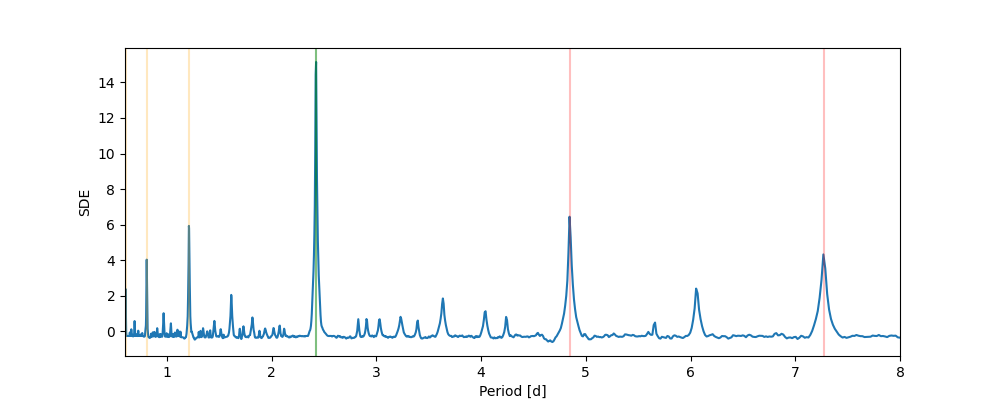

In [9]:
plt.figure(figsize=(10,4))

plt.plot(results.periods, results.power)
# Note: here is periods 

plt.xlabel("Period [d]")
plt.ylabel(r'SDE')

# This must be put here, otherwise it will not work!
plt.xlim(np.amin(results.periods), 8.)

# period from Exoplanet archive
# period from Exoplanet archive
# multiple of the period
for ii in range(2,5):
    plt.axvline(ii*known_period, c='red', alpha=0.25)

# fraction of period
for ii in range(2,10):
    plt.axvline(known_period/ii, c='orange', alpha=0.25)

plt.axvline(known_period, c='green', alpha=0.5)

plt.show()

<IPython.core.display.Javascript object>


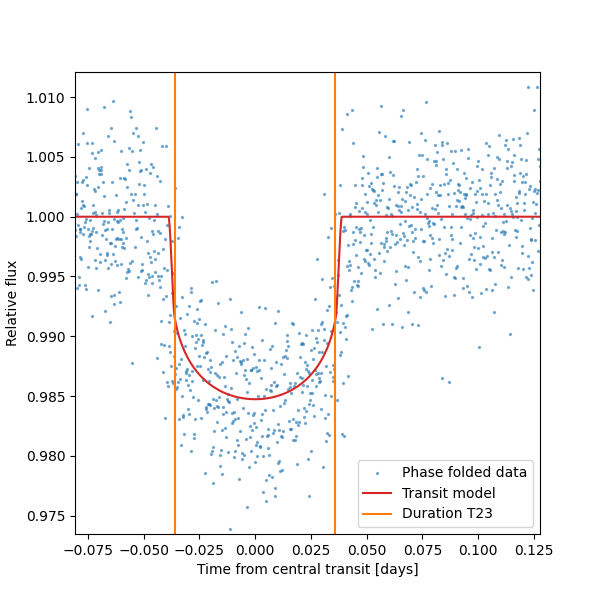

In [10]:
plt.figure(figsize=(6,6))
plt.scatter((results.folded_phase-0.5)*results.period, results.folded_y, c='C0', s=2, alpha=0.5, label='Phase folded data')
plt.plot((results.model_folded_phase-0.5)*results.period, results.model_folded_model, color='C3', label='Transit model')


plt.xlim(-results.period/2, results.period/2.)

plt.axvline(-results.duration/2, c='C1', label='Duration T23')
plt.axvline(results.duration/2, c='C1')
plt.legend()

plt.xlabel("Time from central transit [days]")
plt.ylabel("Relative flux");